In [1]:
%load_ext autoreload
%autoreload
import sys, os
import numpy as np
import scipy.optimize as optimize
import scipy.fftpack as fft
import scipy.integrate as integrate
import scipy.linalg as linalg
from scipy.stats import linregress
import scipy.signal as signal

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from chi2 import *

mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['font.size'] = 15

/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/jean/miniconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def curve_fit( func, x, y, sigma, p0 ):
    fit = optimize.leastsq( lambda args: (func(x, *args)-y)/sigma, x0=p0, full_output=1, ftol=1e-8, gtol=1e-8, xtol=1e-8 )
    cov = fit[1]
    fit = fit[0]
    fitval = func(x, *fit)
    s_sq = np.sum( ((fitval-y)/sigma)**2 )/(len(x) - 2)
    if(len(x)==2):
        s_sq = np.sum( ((fitval-y)/sigma)**2 )/len(x)
    if cov is not None:
        cov = cov * s_sq
        fiterr = np.sqrt(np.diag(cov))
    else:
        print("NONE")
        fiterr = np.ones(len(fit))*1e9
    return fit, fiterr

def least_sq( y, yfit ):
    return sum( (y - yfit)**2 )

In [98]:
n = 200
dt = 1e-4
times_tot = np.arange( 1e4 )*dt
times = np.arange(1e4-2*n)*dt
times = times - max(times)
nyq = 1/dt/2

In [100]:
# d = signal.firwin(101, [0.01, 499.9], nyq=nyq, window='hamming', pass_zero=False)
# w, h = signal.freqz(d, worN=15000)
# plt.figure()
# plt.plot(w/np.pi*nyq, np.absolute(h))
# plt.figure()
# facNorm = (integrate.simps(np.absolute(h)**2, w/np.pi*nyq))
filtup_arr = np.logspace(np.log10(1.5), np.log10(nyq-1), 200)
erravefilt_arr = []
errave_arr = []
phasediff_arr = []
phase_arr_tot = []
phasefilt_arr_tot = []
truephase_arr = []
for filt in filtup_arr:
    print(filt, end=', ')
    d = signal.firwin(101, [0.5, filt], nyq=nyq, window='hamming', pass_zero=False)
#     w, h = signal.freqz(d, worN=15000)
#     plt.figure()
#     plt.plot(w/np.pi*nyq, np.absolute(h))
#     plt.figure()
#     fac = (integrate.simps(np.absolute(h)**2, w/np.pi*nyq))/facNorm
#     print(fac)
    res_arr = []
    resfilt_arr = []
    phase_arr = []
    phasefilt_arr = []
    norm_arr = []
    normfilt_arr = []
    errphase_arr = []
    errphasefilt_arr = []
    errnorm_arr = []
    errnormfilt_arr = []
    phase = 2*np.pi*np.random.rand()
    for i in range(10):
        sig_tot = np.sin(2*np.pi*1*times_tot+phase) + np.random.normal(0,1e-5,size=len(times_tot))
        sig = sig_tot[n:-n].copy()
        filtered_sig = signal.convolve(sig_tot, d, mode='same', method='auto')[n:-n]

        paraOut = optimize.minimize( lambda para: least_sq(sig, para[0]*np.sin(2*np.pi*times) + para[1]*np.cos(2*np.pi*times)), [ 0.1, 0.1 ], method="SLSQP", tol=1e-10, options={'eps': 1e-12, 'ftol':1e-10, 'maxiter':5000} ).x
        paraOut, errtout = curve_fit( lambda t, *para: para[0]*np.sin(2*np.pi*t) + para[1]*np.cos(2*np.pi*t), times, sig, np.ones(len(times)), paraOut)

        paraOut_filt = optimize.minimize( lambda para: least_sq(filtered_sig, para[0]*np.sin(2*np.pi*times) + para[1]*np.cos(2*np.pi*times)), [ 0.1, 0.1 ], method="SLSQP", tol=1e-30, options={'eps': 1e-12, 'ftol':1e-10, 'maxiter':5000} ).x
        paraOut_filt, errtout_filt = curve_fit( lambda t, *para: para[0]*np.sin(2*np.pi*t) + para[1]*np.cos(2*np.pi*t), times, filtered_sig, np.ones(len(times)), paraOut_filt)

        norm_arr.append(np.sqrt(paraOut[1]**2 + paraOut[0]**2))
        normfilt_arr.append(np.sqrt(paraOut_filt[1]**2 + paraOut_filt[0]**2))

        phase_arr.append(np.arctan2(paraOut[1], paraOut[0]))
        phasefilt_arr.append(np.arctan2(paraOut_filt[1], paraOut_filt[0]))

        errphase_arr.append(np.abs(paraOut[0]*paraOut[1])/norm_arr[-1]**(-2) * np.sqrt( (errtout[0]/paraOut[0])**2 + (errtout[1]/paraOut[1])**2 ))
        errphasefilt_arr.append(np.abs(paraOut_filt[0]*paraOut_filt[1])/(paraOut_filt[0]**2+paraOut_filt[1]**2) * np.sqrt( (errtout_filt[0]/paraOut_filt[0])**2 + (errtout_filt[1]/paraOut_filt[1])**2 ))

        errnorm_arr.append(norm_arr[-1]**(-1) * np.sqrt( (errtout[0]*paraOut[0])**2 + (errtout[1]*paraOut[1])**2 ))
        errnormfilt_arr.append(normfilt_arr[-1]**(-1) * np.sqrt( (errtout_filt[0]*paraOut_filt[0])**2 + (errtout_filt[1]*paraOut_filt[1])**2 ))

        res_arr.append(np.sum((paraOut[0]*np.sin(2*np.pi*times) + paraOut[1]*np.cos(2*np.pi*times) - sig)**2))
        resfilt_arr.append(np.sum((paraOut_filt[0]*np.sin(2*np.pi*times) + paraOut_filt[1]*np.cos(2*np.pi*times) - filtered_sig)**2))

    res_arr = np.array(res_arr)
    resfilt_arr = np.array(resfilt_arr)
    phase_arr = np.array(phase_arr)
    phasefilt_arr = np.array(phasefilt_arr)
    norm_arr = np.array(norm_arr)
    normfilt_arr = np.array(normfilt_arr)
    errphase_arr = np.array(errphase_arr)
    errphasefilt_arr = np.array(errphasefilt_arr)
    errnorm_arr = np.array(errnorm_arr)
    errnormfilt_arr = np.array(errnormfilt_arr)
    phasediff_arr.append(phase_arr-phasefilt_arr)
    phase_arr_tot.append(phase_arr)
    phasefilt_arr_tot.append(phasefilt_arr)
    truephase_arr.append(phase)

#     f, ax = plt.subplots(2,1)
#     f.suptitle(filt)
#     ax[0].errorbar(range(len(phasefilt_arr)), phasefilt_arr-np.mean(phasefilt_arr), errphasefilt_arr)
#     ax[1].errorbar(range(len(phase_arr)), phase_arr-np.mean(phase_arr), errphase_arr)
    erravefilt_arr.append(np.mean(errphasefilt_arr))
    errave_arr.append(np.mean(errphase_arr))
erravefilt_arr = np.array(erravefilt_arr)
errave_arr = np.array(errave_arr)
phasediff_arr = np.array(phasediff_arr)
phase_arr_tot = np.array(phase_arr_tot)
phasefilt_arr_tot = np.array(phasefilt_arr_tot)
truephase_arr = np.array(truephase_arr)

1.5, 1.5624053982296469, 1.6274070856114273, 1.6951130771176475, 1.7656358815321864, 1.839092688409233, 1.9156055628101731, 1.9953016481422365, 2.078313377435961, 2.164778693412557, 2.2548412777068667, 2.3486507896268285, 2.446363114846186, 2.548140624443717, 2.654152444719417, 2.764574738236021, 2.8795909965528477, 2.9993923451384386, 3.1241778609686506, 3.254154903337981, 3.389539458433823, 3.5305564982462663, 3.6774403544098164, 3.8304351075982948, 3.9897949931199563, 4.155784823386824, 4.328680427960275, 4.508769111904102, 4.696350133206706, 4.891735200065785, 5.095248988861842, 5.307229683681261, 5.528029538285482, 5.758015461460119, 5.997569626716708, 6.2470901073602345, 6.506991537977769, 6.7777058034473985, 7.059682756612415, 7.353390965813326, 7.659318493519905, 7.977973707357111, 8.309886124872625, 8.655607293449753, 9.015711706827863, 9.390797759753386, 9.781488742347708, 10.188433875844382, 10.612309391416712, 11.053819653888436, 11.51369833219484, 11.992709618539262, 12.49

(0, 200)

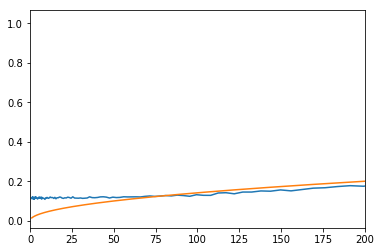

In [147]:
filtwidth_arr = filtup_arr-0.5
plt.plot(filtwidth_arr, erravefilt_arr/np.mean(errave_arr))
plt.plot(filtwidth_arr, 1/np.sqrt(nyq)*filtwidth_arr**0.5)
plt.xlim(0,200)

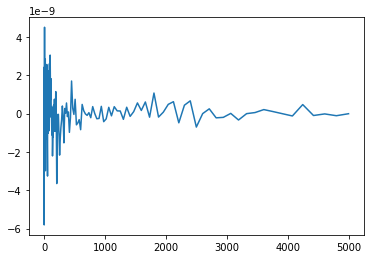

In [103]:
plt.plot(filtwidth_arr, np.mean(phasediff_arr, axis=1))

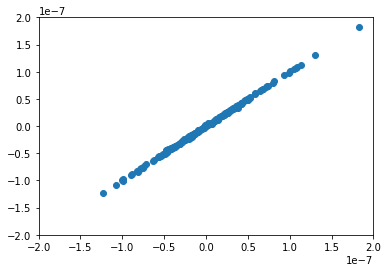

In [123]:
diff_filt = np.mod(np.mean(phasefilt_arr_tot, axis=1), 2*np.pi)- np.mod(truephase_arr, 2*np.pi)
diff = np.mod(np.mean(phase_arr_tot, axis=1), 2*np.pi)- np.mod(truephase_arr, 2*np.pi)
plt.scatter(diff_filt - np.mean(diff[diff<1]), diff - np.mean(diff[diff<1]))
#plt.xscale("log")
plt.ylim(-2e-7,2e-7)
plt.xlim(-2e-7, 2e-7)
plt.show()
#plt.plot(filtwidth_arr, np.mod(np.mean(phasefilt_arr_tot, axis=1), 2*np.pi)-np.mod(truephase_arr, 2*np.pi))

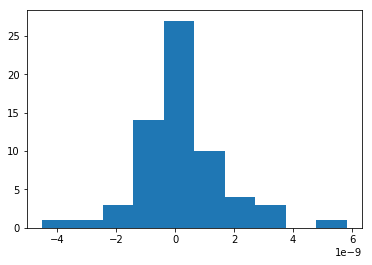

In [142]:
i = np.argmin(np.abs(filtwidth_arr-20))
plt.hist((diff_filt-diff)[:i]);